# Implementing Self-supervised Learning on CIFAR-10

Let's import the necessary libraries

In [ ]:
try:
    from astra.torch.models import ResNetClassifier
    import umap.umap_ as umap
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA
    %pip install umap-learn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import pandas as pd
import umap.umap_ as umap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import EfficientNet, MLP, MLPClassifier, EfficientNetClassifier

from itertools import permutations,product

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/vannsh.jani/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Data

In [3]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

### Plotting some images

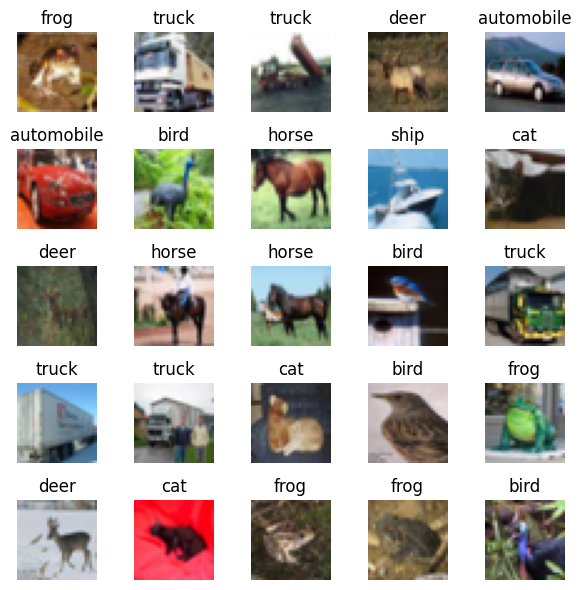

In [4]:
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

### Splitting Data

In [5]:
n_train = 10000
n_test = 35000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [6]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

10000 15000 35000


In [ ]:
ecf = EfficientNetClassifier(n_classes=10).to(device) 

In [ ]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    with torch.no_grad():
        for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
            X_dataset = X[idx].to(device)
            y_dataset = y[idx].to(device)
            y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
            print(f'{name} set accuracy: {acc*100:.2f}%')
            if plot_confusion_matrix:
                cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
                cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d' , cmap='Blues')
                # Rotate the labels on x-axis to make them readable
                _ = plt.xticks(rotation=90)
                plt.show()

### Training model on train set

In [ ]:
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_idx], y[train_idx], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=True)

In [ ]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

In [ ]:
predict(ecf, dataset.classes, plot_confusion_matrix=True)

In [ ]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])
iter_losses, epoch_losses = train_fn(ecf,nn.CrossEntropyLoss(), X[train_plus_pool_idx], y[train_plus_pool_idx],
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

In [ ]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

In [ ]:
predict(ecf, dataset.classes, plot_confusion_matrix=True)

## SSL

Task: Dividing images into patches and permuting them. Predict the permutation number as a classification task

In [7]:
X_pool = X[pool_idx]
y_pool = y[pool_idx]

X_pool.shape, y_pool.shape

(torch.Size([15000, 3, 32, 32]), torch.Size([15000]))

In [8]:
# Divinding image into 4 patches of 8x8
def divide_into_patches(images):                  # images = (#,3,32,32), # = number of images
  patches = torch.split(images,16,dim=3)
  patches = [torch.unsqueeze(patch,1) for patch in patches]
  patches = torch.cat(patches,dim=1)
  patches = torch.split(patches,16,dim=3)
  patches = torch.cat(patches,dim=1)
  return patches


images_with_patches = divide_into_patches(X_pool)
images_with_patches.shape

torch.Size([15000, 4, 3, 16, 16])

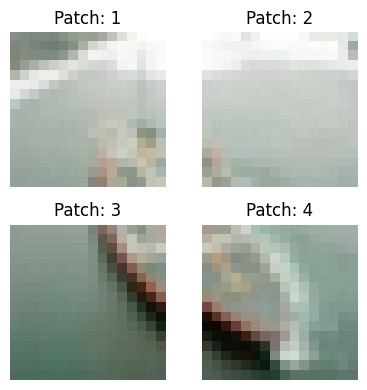

In [9]:
# Viusalizing patches
sample_image = images_with_patches[0]
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(torch.einsum("chw->hwc", sample_image[i]))
    plt.axis('off')
    plt.title(f"Patch: {i+1}")
plt.tight_layout()

torch.Size([3, 32, 32])


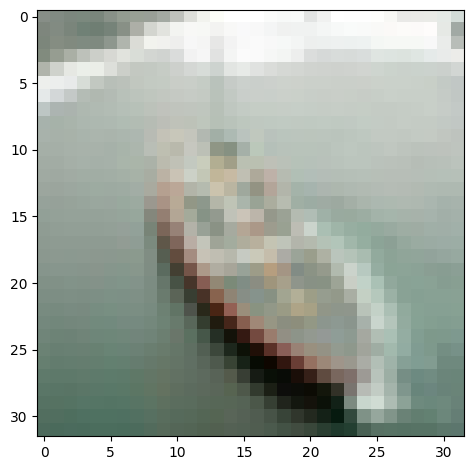

In [10]:
# Original image
print(X_pool[0].shape)
plt.imshow(torch.einsum("chw->hwc", X_pool[0]))
plt.tight_layout()

In [11]:
def get_ranks(a):
    val = 0
    ranked_indices = torch.argsort(a)
    ranks = torch.zeros_like(ranked_indices)
    for i in range(len(ranked_indices)-1):
        if i==len(ranked_indices)-2:
            if a[ranked_indices[i]] == a[ranked_indices[i+1]]:
                ranks[ranked_indices[i]] = val
                ranks[ranked_indices[i+1]] = val
            else:
                ranks[ranked_indices[i]] = val
                ranks[ranked_indices[i+1]] = val+1
            break
        ranks[ranked_indices[i]] = val
        if a[ranked_indices[i]] != a[ranked_indices[i+1]]:
            val += 1
            continue
        else:
            continue
    return ranks


def temp_func(image):
    #image shape is (4,3,16,16)
    y_labels = []
    p_image = torch.unsqueeze(image,0)
    perms = torch.tensor(list(permutations(range(4))))
    for i in range(len(perms)):
        y_labels.append(i)
        p_image = torch.cat([p_image,torch.unsqueeze(image[perms[i]],0)],dim=0)
    p_image = p_image[1:]
    y_labels = torch.tensor(y_labels)
    return p_image,y_labels

def permute_image(images,number_of_permutations,type):
    p_image,y_labels = torch.vmap(temp_func)(images)
    if type == 'all':
        return p_image,y_labels
    elif type == 'random':
        idxs = torch.randint(low = 0,high = 24,size=(number_of_permutations,))
        p_image = p_image[:,idxs]
        y_labels = y_labels[:,idxs]
    return p_image,y_labels
        

def permute_patches(images,number_of_permutations=10,type='random'):
    
    all_permuted_images,y_labels = permute_image(images,number_of_permutations,type)
    all_permuted_images = all_permuted_images.reshape(-1,4,3,16,16)
    y_labels = y_labels.reshape(-1)
    y_labels = get_ranks(y_labels)
    return all_permuted_images,y_labels

permuted_images,y_labels = permute_patches(images_with_patches,10,'random')
permuted_images.shape,y_labels.shape
    

(torch.Size([150000, 4, 3, 16, 16]), torch.Size([150000]))

In [12]:
class SSL_Model(nn.Module):
    def __init__(self,number_of_permutations=10):
        super().__init__()
        self.model = EfficientNet()
        self.fc1 = nn.Linear(1280, 256)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, number_of_permutations)
        self.softmax = nn.Softmax(dim=1)
 
        
    def forward(self, p1,p2,p3,p4):
        p1 = self.model(p1)  # (128, 1280)
        p2 = self.model(p2)
        p3 = self.model(p3)
        p4 = self.model(p4)
        p1 = F.relu(self.fc1(p1)) # (128, 256)
        p2 = F.relu(self.fc1(p2))
        p3 = F.relu(self.fc1(p3))
        p4 = F.relu(self.fc1(p4))
        x = torch.cat([p1,p2,p3,p4],dim=1) # (128, 1024)
        x = F.relu(self.fc2(x))  # (128, 256)
        x = self.softmax(self.fc3(x))  # (128, 10)
        return x


In [13]:
def train_ssl_model(model, loss_fn, images, labels, lr=3e-4, batch_size=512, epochs=30, verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    iter_losses = []
    epoch_losses = []

    for epoch in range(epochs):
        for i in range(0, len(images), batch_size):
            model.train()
            optimizer.zero_grad()
            p1, p2, p3, p4 = images[i:i + batch_size][:, 0], images[i:i + batch_size][:, 1], images[i:i + batch_size][:, 2], images[i:i + batch_size][:, 3]
            p1 = p1.to(device)
            p2 = p2.to(device)
            p3 = p3.to(device)
            p4 = p4.to(device)
            flat_labels = labels[i:i + batch_size]
            y_pred_prob = model(p1, p2, p3, p4).to(device)
            loss = loss_fn(y_pred_prob, flat_labels.to(device))
            loss.backward()
            optimizer.step()
            iter_losses.append(loss.item())

        epoch_losses.append(loss.item())
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}, loss={loss.item():.4f}")

    return iter_losses, epoch_losses


In [30]:
# predict permutations and get accuracy

def predict_permutations(model,images,labels):
    with torch.no_grad():
        model.eval()
        p1,p2,p3,p4 = images[:,0],images[:,1],images[:,2],images[:,3]
        p1 = p1.to(device)
        p2 = p2.to(device)
        p3 = p3.to(device)
        p4 = p4.to(device)
        y_pred_prob = model(p1,p2,p3,p4).to(device)
        y_pred = torch.argmax(y_pred_prob,dim=1)
        return y_pred

def results(y_labels,y_pred):
    y_labels = y_labels.to(device) 
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
    unique_labels = np.unique(y_labels.cpu())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
    plt.show()

Epoch 1/25, loss=2.2398
Epoch 2/25, loss=2.0250
Epoch 3/25, loss=1.9437
Epoch 4/25, loss=1.8978
Epoch 5/25, loss=1.8544
Epoch 6/25, loss=1.7603
Epoch 7/25, loss=1.7365
Epoch 8/25, loss=1.7141
Epoch 9/25, loss=1.7044
Epoch 10/25, loss=1.7021
Epoch 11/25, loss=1.6958
Epoch 12/25, loss=1.6901
Epoch 13/25, loss=1.6869
Epoch 14/25, loss=1.6832
Epoch 15/25, loss=1.6776
Epoch 16/25, loss=1.6786
Epoch 17/25, loss=1.6743
Epoch 18/25, loss=1.6708
Epoch 19/25, loss=1.6682
Epoch 20/25, loss=1.6679
Epoch 21/25, loss=1.6663
Epoch 22/25, loss=1.6665
Epoch 23/25, loss=1.6652
Epoch 24/25, loss=1.6619
Epoch 25/25, loss=1.6618


Text(0, 0.5, 'Training loss')

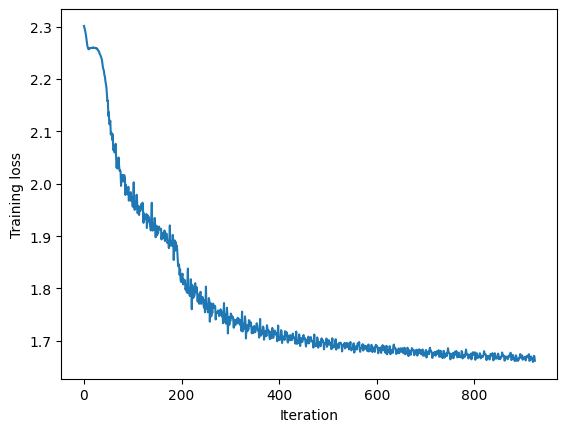

In [14]:


ssl_model = SSL_Model().to(device)
iter_losses, epoch_losses = train_ssl_model(ssl_model,nn.CrossEntropyLoss(),permuted_images,y_labels,lr=3e-4,
                                     batch_size=4096, epochs=25, verbose=True)

plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")


Accuracy = 0.7916266918182373


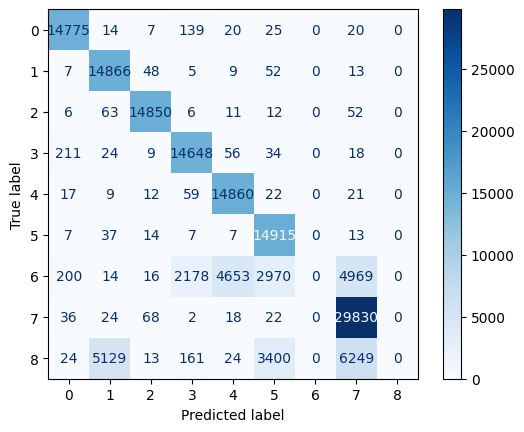

In [31]:
y_pred = predict_permutations(ssl_model,permuted_images,y_labels)
results(y_labels,y_pred)